# Segmentation Analysis
The dataset contains info of ~2000 induviduals from a county. The information contained comes from purchasing behavior from the loyalty card of an FMCG store. All customer info is protected. We are looking to deploy clustering techniques to identify any patterns.

In [2]:
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import pickle


In [3]:
df= pd.read_csv('segmentation_data.csv', index_col=0)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [5]:
print(df.describe().transpose())
print(df.info())
print(df.corr())

                  count         mean           std      min       25%  \
Sex              2000.0       0.4570      0.498272      0.0      0.00   
Marital status   2000.0       0.4965      0.500113      0.0      0.00   
Age              2000.0      35.9090     11.719402     18.0     27.00   
Education        2000.0       1.0380      0.599780      0.0      1.00   
Income           2000.0  120954.4190  38108.824679  35832.0  97663.25   
Occupation       2000.0       0.8105      0.638587      0.0      0.00   
Settlement size  2000.0       0.7390      0.812533      0.0      0.00   

                      50%        75%       max  
Sex                   0.0       1.00       1.0  
Marital status        0.0       1.00       1.0  
Age                  33.0      42.00      76.0  
Education             1.0       1.00       3.0  
Income           115548.5  138072.25  309364.0  
Occupation            1.0       1.00       2.0  
Settlement size       1.0       1.00       2.0  
<class 'pandas.core.fra

## Correlation and Visualization of raw data

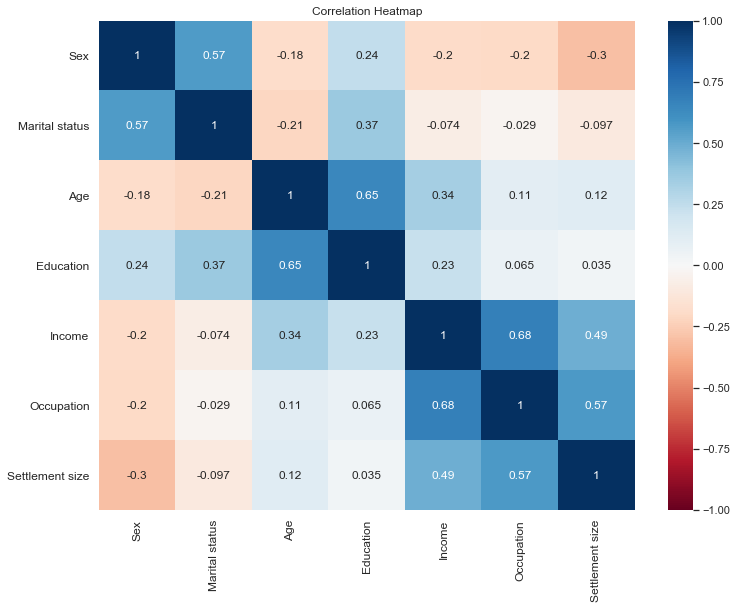

In [7]:
plt.figure(figsize = (12, 9))
s = sns.heatmap(df.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

Text(0.5, 1.0, 'Visualization of raw data')

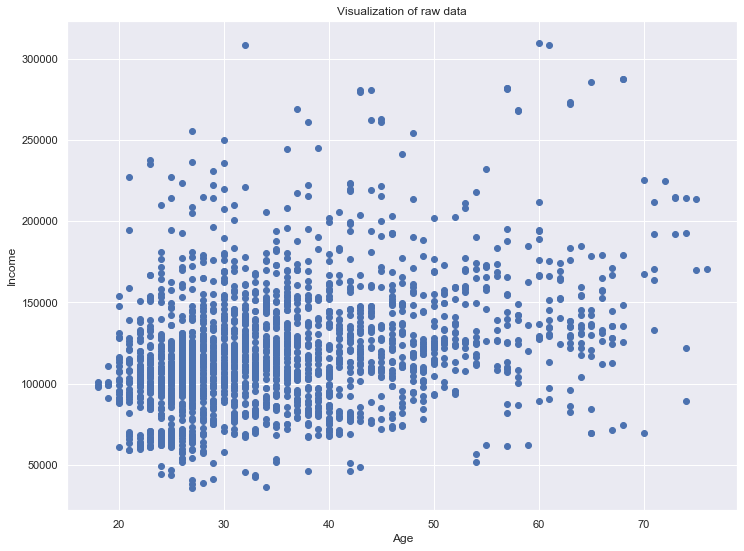

In [8]:
plt.figure(figsize = (12, 9))
plt.scatter(df.iloc[:, 2], df.iloc[:, 4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Visualization of raw data')

In [9]:
#Standardization
scaler=StandardScaler()
segmentation_std=scaler.fit_transform(df)

## Hierarchical Clustering

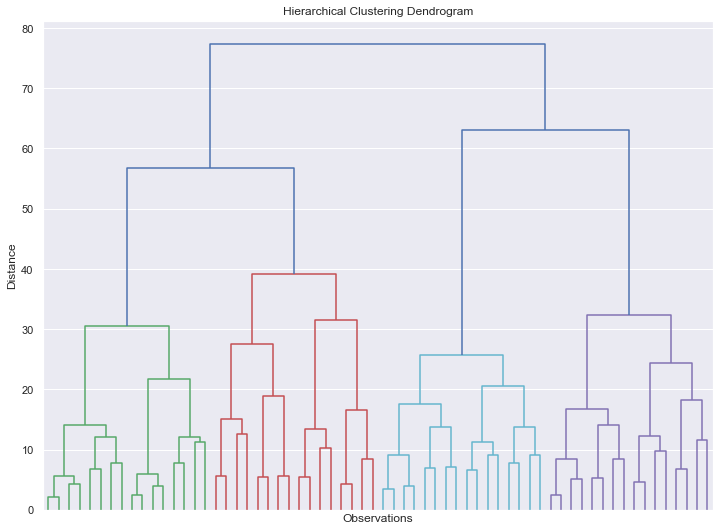

In [11]:
hier_clust = linkage(segmentation_std, method = 'ward')

plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()


## K-means Clustering

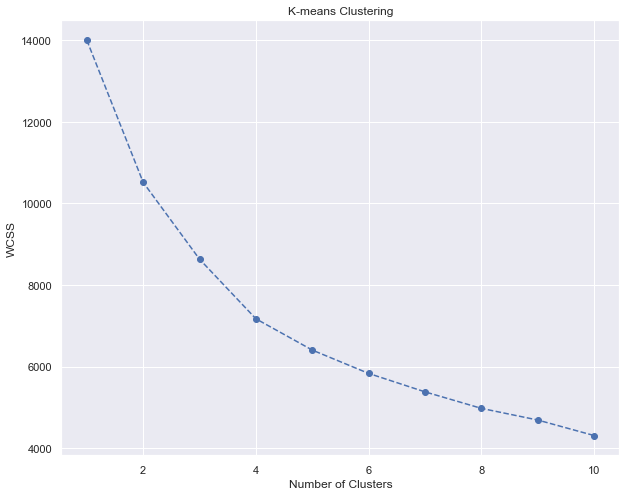

In [12]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [13]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(segmentation_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [15]:
df_segm_kmeans = df.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_


df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


In [16]:
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [17]:
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'standard',
                         3:'career focused'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
standard,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
career focused,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [18]:
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off', 
                                                                  1:'fewer opportunities',
                                                                  2:'standard', 
                                                                  3:'career focused'})

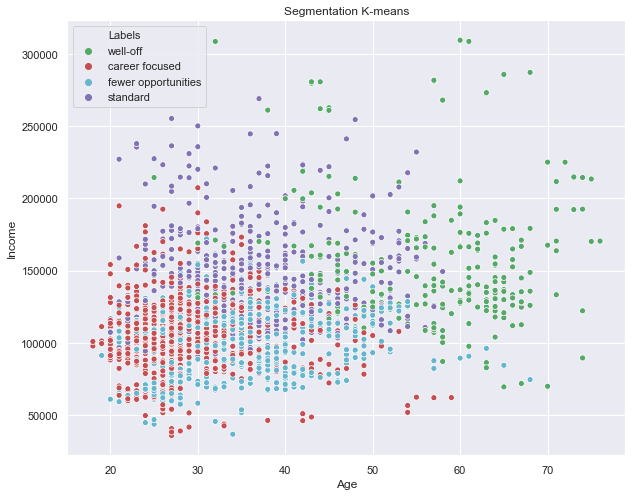

In [19]:
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

## PCA

In [21]:
pca = PCA()
print(pca.fit(segmentation_std))
print(pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
[0.35696328 0.26250923 0.18821114 0.0755775  0.05716512 0.03954794
 0.02002579]


Text(0, 0.5, 'Cumulative Explained Variance')

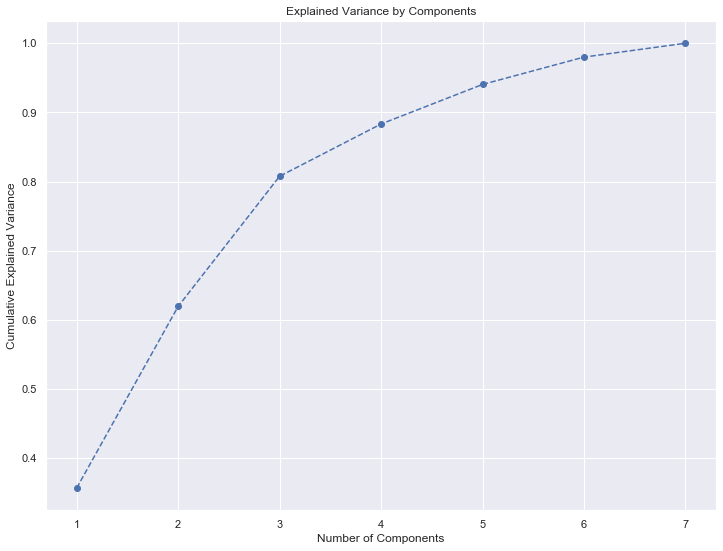

In [23]:
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [24]:
pca = PCA(n_components = 3)

pca.fit(segmentation_std)


PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [25]:
pca.components_


array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [27]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


([<matplotlib.axis.YTick at 0x1a279b0450>,
 <a list of 3 Text yticklabel objects>)

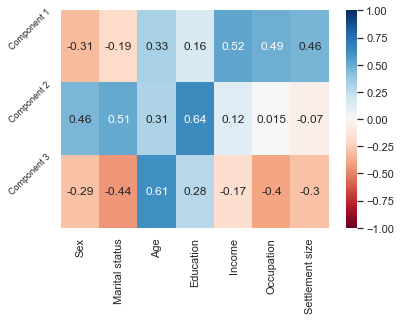

In [28]:
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)

In [29]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [30]:
scores_pca = pca.transform(segmentation_std)

## K-means clustering with PCA

In [31]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

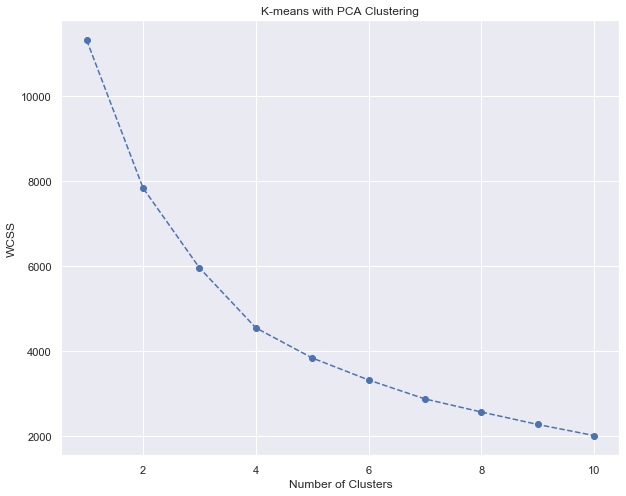

In [32]:

plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [33]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [35]:
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,3
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,3
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,1
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,1
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,2


In [36]:
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953
1,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493
2,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925
3,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046


In [37]:
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
standard,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,264,0.1320
career focused,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493,459,0.2295
fewer opportunities,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925,694,0.3470
well-off,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915


In [38]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'standard', 
                                                          1:'career focused',
                                                          2:'fewer opportunities', 
                                                          3:'well-off'})


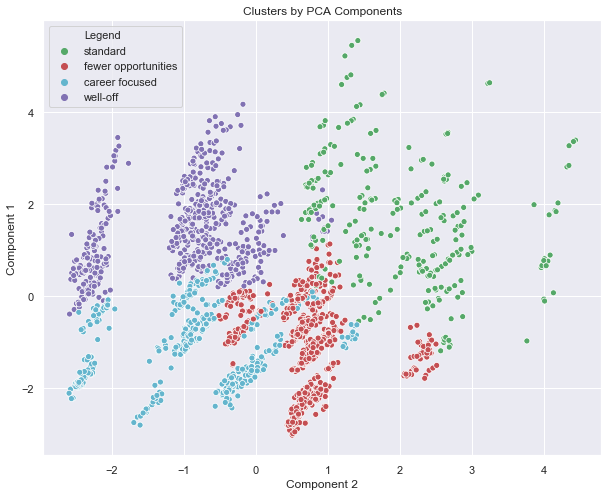

In [39]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

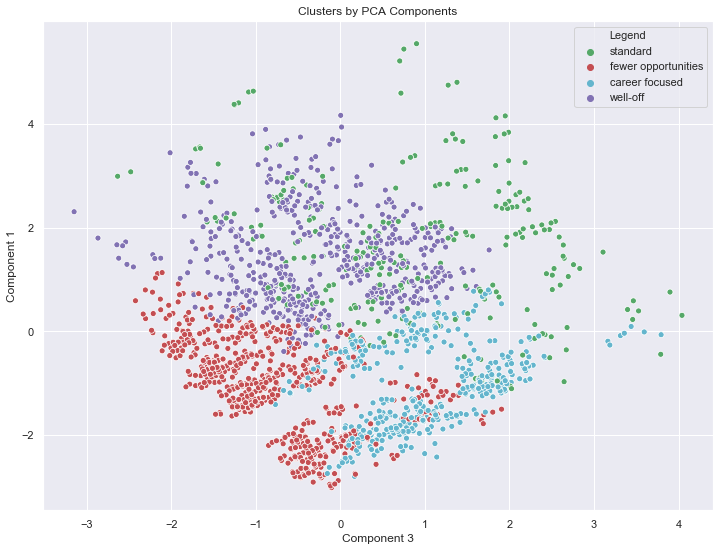

In [40]:
x_axis_1 = df_segm_pca_kmeans['Component 3']
y_axis_1 = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (12, 9))
sns.scatterplot(x_axis_1, y_axis_1, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

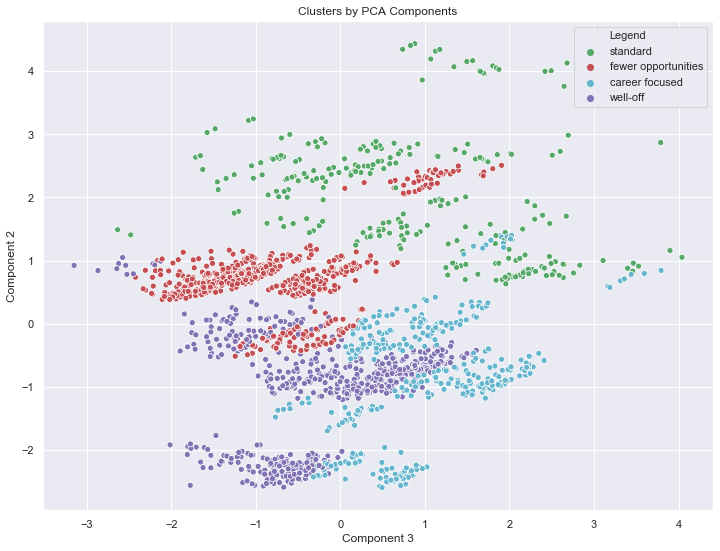

In [41]:
x_axis_1 = df_segm_pca_kmeans['Component 3']
y_axis_1 = df_segm_pca_kmeans['Component 2']
plt.figure(figsize = (12, 9))
sns.scatterplot(x_axis_1, y_axis_1, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components' )
plt.show()

## Pickle export

In [42]:
pickle.dump(scaler, open('scaler.pickle', 'wb'))
pickle.dump(pca, open('pca.pickle', 'wb'))
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))